# Sponge attack against LLM

*Demonstrate different effects of sponge attacks on free (open-source) LLMs.*

List of open-source LLMs: [GitHub List](https://github.com/eugeneyan/open-llms)

## Test 1

- Model: [Bloomz-560m](https://huggingface.co/bigscience/bloom-560m)
- Python version 3.13.1

To be able to run the code properly, run the code below:
```
pip install transformers torch psutil matplotlib
```

In [17]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, time, psutil
import matplotlib.pyplot as plt

model_name = "bigscience/bloomz-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
# Prepare different prompt sizes
prompt_sizes = [100, 200, 300, 400, 500, 1000, 10000]  # number of words
results = []

for size in prompt_sizes:
    sponge_prompt = "hello " * size
    inputs = tokenizer(sponge_prompt, return_tensors="pt", truncation=False).to(device)

    # Reset GPU memory tracker if using GPU
    if device == "cuda":
        torch.cuda.reset_peak_memory_stats()

    # Measure memory before
    mem_before = process.memory_info().rss / (1024 * 1024)  # in MB

    # Time start
    start_time = time.time()

    try:
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,
            do_sample=False
        )
        crashed = False
    except Exception as e:
        print("Error:", str(e))
        crashed = True
        outputs = None

    # Time end
    end_time = time.time()

    # Measure memory after
    mem_after = process.memory_info().rss / (1024 * 1024)  # in MB
    peak_mem_gpu = torch.cuda.max_memory_allocated(device) / (1024 * 1024) if device == "cuda" else None

    results.append({
        "prompt_words": size,
        "tokens": inputs['input_ids'].shape[1],
        "time_taken_sec": end_time - start_time,
        "memory_used_mb": mem_after - mem_before,
        "peak_gpu_mem_mb": peak_mem_gpu,
        "crashed": crashed
    })

Error: [enforce fail at alloc_cpu.cpp:115] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6401280064 bytes.


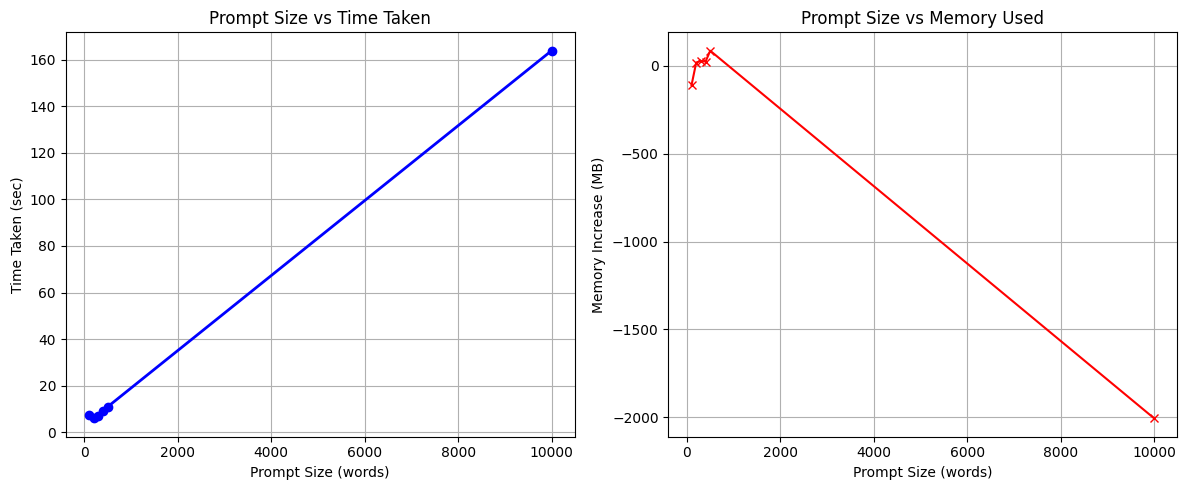

In [28]:
import matplotlib.pyplot as plt

# Create diagrams
prompt_sizes = [r["prompt_words"] for r in results]
times = [r["time_taken_sec"] for r in results]
memory = [r["memory_used_mb"] for r in results]

plt.figure(figsize=(12,5))

# Plot time
plt.subplot(1,2,1)
plt.plot(prompt_sizes, times, marker="o", color="blue", linewidth=2)
plt.grid(True)
plt.title("Prompt Size vs Time Taken")
plt.xlabel("Prompt Size (words)")
plt.ylabel("Time Taken (sec)")

# Plot memory
plt.subplot(1,2,2)
plt.plot(prompt_sizes, memory, marker="x", color="r")
plt.title("Prompt Size vs Memory Used")
plt.xlabel("Prompt Size (words)")
plt.grid(True)
plt.ylabel("Memory Increase (MB)")

plt.tight_layout()
plt.show()
